# <center>Data Exploration</center>

In [1]:
import numpy as np
import pandas as pd

import preprocessing
import cgan
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas_profiling
from sklearn.preprocessing import RobustScaler

Using TensorFlow backend.


In [2]:
#Load Data
train,test, label_mapping = preprocessing.get_data(encoding="Label")
data_cols = list(train.columns[ train.columns != 'label' ])
x_train , x_test = preprocessing.preprocess(train,test,data_cols,"Robust",True)
train, test = None, None
y_train = x_train.label.values
y_test = x_test.label.values

In [3]:
data_cols = list(x_train.columns[ x_train.columns != 'label' ])

to_drop = preprocessing.get_contant_featues(x_train,data_cols,threshold=0.995)
x_train.drop(to_drop, axis=1,inplace=True)
x_test.drop(to_drop, axis=1,inplace=True)

data_cols = list(x_train.columns[ x_train.columns != 'label' ])
print("Total data features : {}".format(len(data_cols)))

Total data features : 25


In [4]:
x_train.max(axis=0)

duration                          1.073651
protocol_type                     1.000000
service                           1.064516
flag                              1.111111
src_bytes                       628.794266
dst_bytes                      5638.329329
wrong_fragment                    1.000000
hot                               2.566667
logged_in                         1.000000
num_compromised                1495.800000
is_guest_login                    1.000000
count                             0.974510
srv_count                         0.986275
same_srv_rate                     0.000000
diff_srv_rate                     1.000000
srv_diff_host_rate                1.000000
dst_host_count                    0.000000
dst_host_srv_count                0.755906
dst_host_same_srv_rate            0.490000
dst_host_diff_srv_rate            0.980000
dst_host_same_src_port_rate       1.000000
dst_host_srv_diff_host_rate       1.000000
dst_host_serror_rate              1.000000
dst_host_re

### Try to remove outliers without losing much data

In [5]:
Q1 = x_train.drop('label',axis=1).quantile(0.1)
Q3 = x_train.drop('label',axis=1).quantile(0.99)
IQR = Q3 - Q1
print(IQR)

duration                       0.239977
protocol_type                  1.000000
service                        0.838710
flag                           0.555556
src_bytes                      0.024852
dst_bytes                      0.109841
wrong_fragment                 0.000000
hot                            0.100000
logged_in                      1.000000
num_compromised                0.200000
is_guest_login                 0.000000
count                          1.000000
srv_count                      0.962745
same_srv_rate                  0.970000
diff_srv_rate                  1.000000
srv_diff_host_rate             1.000000
dst_host_count                 0.960630
dst_host_srv_count             0.996063
dst_host_same_srv_rate         0.990000
dst_host_diff_srv_rate         1.000000
dst_host_same_src_port_rate    1.000000
dst_host_srv_diff_host_rate    0.520000
dst_host_serror_rate           1.000000
dst_host_rerror_rate           1.000000
dst_host_srv_rerror_rate       1.000000


In [24]:
#Remove samples containing extreme values
mask = ~((x_train.drop('label',axis=1) < (Q1 - 1.5 * IQR)) | \
         (x_train.drop('label',axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)


In [7]:
x_train[mask].max(axis=0)

duration                       0.595928
protocol_type                  1.000000
service                        1.064516
flag                           1.111111
src_bytes                      0.048543
dst_bytes                      0.274548
wrong_fragment                 0.000000
hot                            0.166667
logged_in                      1.000000
num_compromised                0.400000
is_guest_login                 0.000000
count                          0.974510
srv_count                      0.986275
same_srv_rate                  0.000000
diff_srv_rate                  1.000000
srv_diff_host_rate             1.000000
dst_host_count                 0.000000
dst_host_srv_count             0.755906
dst_host_same_srv_rate         0.490000
dst_host_diff_srv_rate         0.980000
dst_host_same_src_port_rate    1.000000
dst_host_srv_diff_host_rate    1.000000
dst_host_serror_rate           1.000000
dst_host_rerror_rate           1.000000
dst_host_srv_rerror_rate       1.000000


In [9]:
#Remove all Normal data samples
x_train = x_train[mask]
y_train = y_train[mask]

att_ind = np.where(x_train.label != label_mapping["normal"])[0]
for_test = np.where(x_test.label != label_mapping["normal"])[0]

del label_mapping["normal"]

x = x_train[data_cols].values[att_ind]
y = y_train[att_ind]

In [19]:
#---------------------Set GAN parameters--------------------#
rand_dim = 32
base_n_count = 27
n_layers = 4
combined_ep = 1000 #500
batch_size = 64 if len(x) > 128 else len(x)
ep_d , ep_g = 1, 1
learning_rate = 0.001 #5e-5
Optimizer = 'sgd'
activation = 'tanh'
args = [rand_dim,n_layers,combined_ep ,batch_size,ep_d,ep_g,activation,Optimizer,learning_rate,base_n_count]

In [20]:
model = cgan.CGAN(args,x,y.reshape(-1,1))
model.train()
model.dump_to_file()

[0 2 3 4]
Conditional GAN Training : Started!
Conditional GAN Train : Finished!
Save Model : DONE


In [21]:
import numpy as np
import pickle, os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
# a = os.listdir('logs')

( _, _, filenames) = next(os.walk('logs'))


In [25]:
def plot_summary(d_l, g_l,acc_r,acc_g, m =''):
    n = np.arange(len(d_l))
    title = 'Loss and Accuracy plot'+'\n'+ m
    title = title.replace('.pickle','')
    fig, axs = plt.subplots(2,figsize=(19.20,10.80))

    axs[0].set_title(title,fontsize=20.0,fontweight="bold")
    axs[0].plot(n, g_l,label='Generator loss',linewidth=4)
    axs[0].plot(n, d_l,label='Discriminator loss',linewidth=4)
    axs[0].legend(loc=0, prop={'size': 20})
    axs[0].set_ylabel('Loss',fontsize=20.0,fontweight="bold")
    axs[0].tick_params(labelsize=20)
    axs[0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False,labelsize=20)

    # axs[1].plot(n, acc,'r',label='Discriminator accuracy',linewidth=4)
    axs[1].plot(n, acc_g,label='Accuracy on Generated',linewidth=4)
    axs[1].plot(n, acc_r,label='Accuracy on Real',linewidth=4)
    axs[1].legend(loc=0,prop={'size': 20})
    axs[1].set_ylabel('Accuracy',fontsize=20.0,fontweight="bold")
    axs[1].set_xlabel('Ephoc',fontsize=20.0,fontweight="bold")
    axs[1].tick_params(labelsize=20)

    plt.tight_layout()
    plt.show()
#     if not os.path.exists("imgs"):
#         os.makedirs('imgs')
#     plt.savefig(f'imgs/{m[:-7]}.png',dpi = 300)
#     plt.close('all') #plt.close(fig)


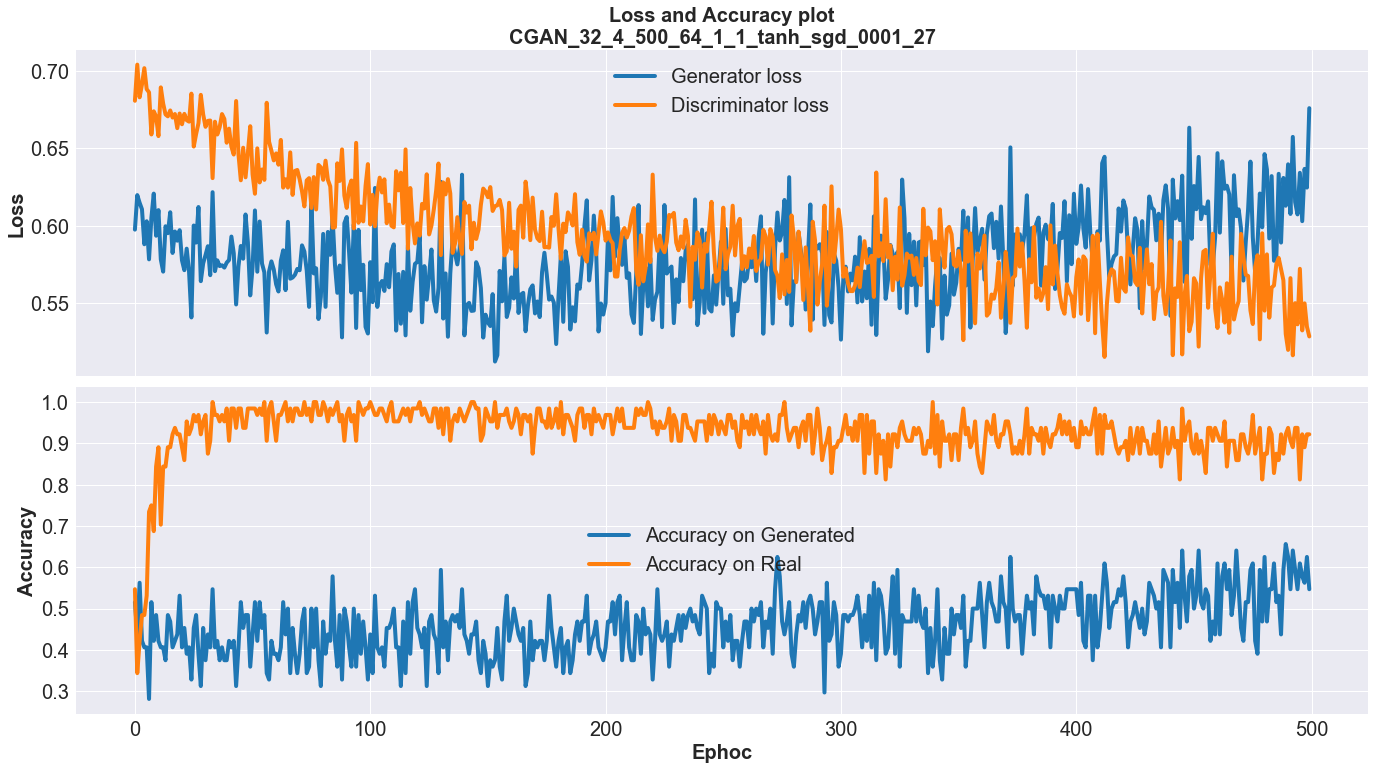

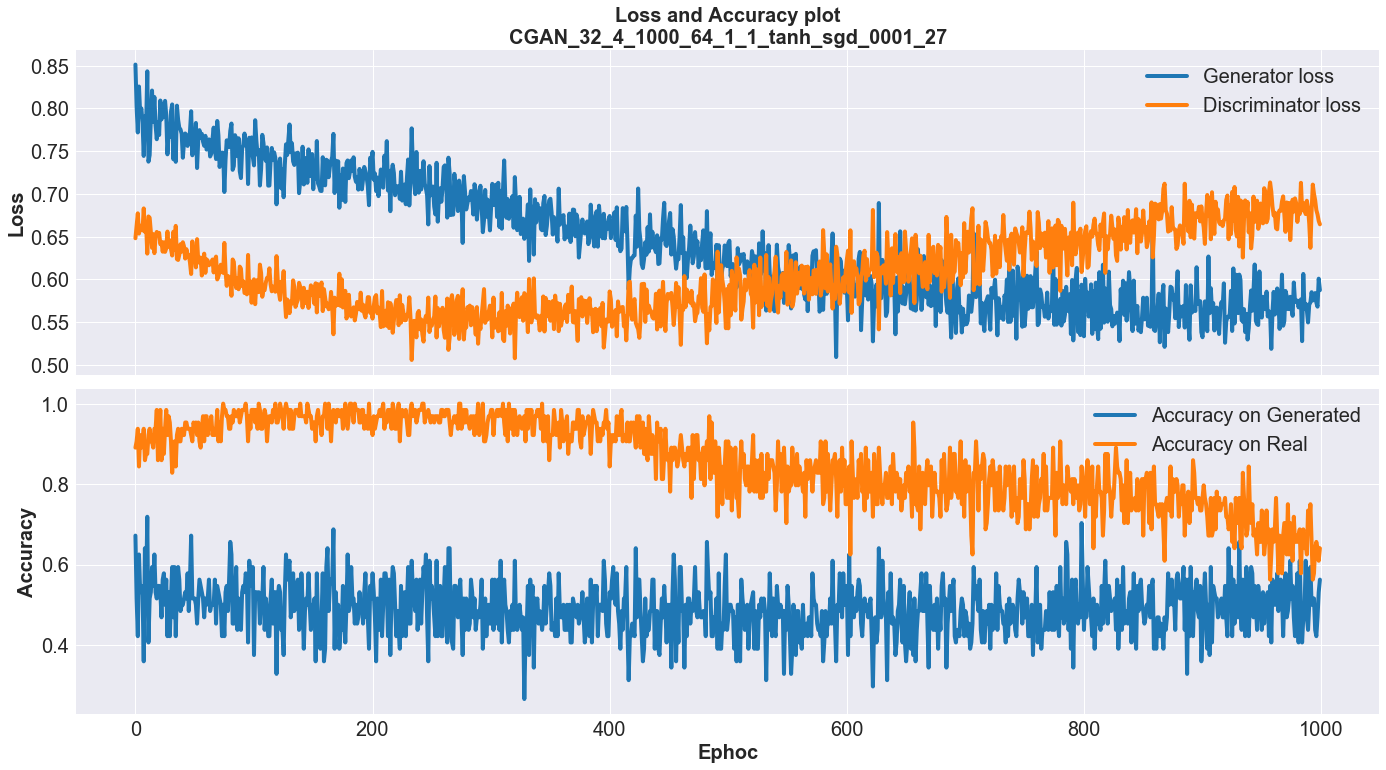

In [26]:
for filename in filenames :
    with open('logs/'+filename, 'rb') as f:
        x = pickle.load(f)

    d_l = np.array(x['discriminator_loss']).ravel()
    g_l = np.array(x['Generator_loss']).ravel()
    acc_history = np.array(x['acc_history'])
    acc = acc_history.sum(axis=1) * 0.5
    acc_real = acc_history[:,1]
    acc_gen = acc_history[:,0]

    plot_summary(d_l, g_l,acc_real,acc_gen,filename)

### <center>TSNE </center>
Didn't work!!

In [ ]:
val, counts = np.unique(y,return_counts=True)
gen_labels = np.array([i.tolist() for j in zip(val,counts) for i in np.repeat(j[0],j[1])])[:,np.newaxis]
gen_train = model.generate_data(gen_labels)

In [ ]:
Real_embedded = TSNE(n_components=2,n_iter=500,verbose=1).fit_transform(x)
Fake_embedded =  TSNE(n_components=2,n_iter=500,verbose=1).fit_transform(gen_train)

In [ ]:
# plt.figure(figsize=(16,10))
# palette = sns.color_palette("bright", 4)
# sns.scatterplot(Real_embedded[:,0], Real_embedded[:,1], hue=y, legend='full', palette=palette)
# sns.scatterplot(Fake_embedded[:,0], Fake_embedded[:,1], hue=gen_labels, legend='full', palette=palette)
# plt.show()

In [ ]:
mask = np.where(y == 3)
plt.figure(figsize=(16,10))
palette = sns.color_palette("bright", 4)
plt.scatter(Real_embedded[mask,0], Real_embedded[mask,1])
plt.scatter(Fake_embedded[mask,0], Fake_embedded[mask,1])
plt.show()

## <center>Explore each attack separately</center>

In [ ]:
train,test, label_mapping = preprocessing.get_data(encoding="Label")
data_cols = list(train.columns[ train.columns != 'label' ])
x_train , x_test = preprocessing.preprocess(train,test,data_cols,"Robust",True)
train, test = None, None
y_train = x_train.label.values
y_test = x_test.label.values

In [ ]:
data_cols = list(x_train.columns[ x_train.columns != 'label' ])
to_drop = preprocessing.get_contant_featues(x_train,data_cols,threshold=0.99)
x_train.drop(to_drop, axis=1,inplace=True)
x_test.drop(to_drop, axis=1,inplace=True)
data_cols = list(x_train.columns[ x_train.columns != 'label' ])

In [ ]:
print("Total data features : {}".format(len(data_cols)))

### <center>normal</center>

In [ ]:
normal_df = x_train.query('label == 1')
print("# of samples : {}".format(normal_df.shape[0]))

In [ ]:
normal_df[data_cols]

In [ ]:
Q1 = normal_df[data_cols].quantile(0.25)
Q3 = normal_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

### <center>dos</center>

In [ ]:
dos_df = x_train.query('label == 0')
print("# of samples : {}".format(dos_df.shape[0]))

In [ ]:
Q1 = dos_df[data_cols].quantile(0.25)
Q3 = dos_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

### <center>probe</center>

In [ ]:
probe_df = x_train.query('label == 2')
print("# of samples : {}".format(probe_df.shape[0]))

In [ ]:
Q1 = probe_df[data_cols].quantile(0.25)
Q3 = probe_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
probe_df.query("src_bytes > 10 or dst_bytes > 10")

### <center>r2l</center>

In [ ]:
r2l_df = x_train.query('label == 3')
print("# of samples : {}".format(r2l_df.shape[0]))

In [ ]:
Q1 = r2l_df[data_cols].quantile(0.25)
Q3 = r2l_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

### <center>u2r</center>

In [ ]:
u2r_df = x_train.query('label == 4')
print("# of samples : {}".format(u2r_df.shape[0]))

In [ ]:
Q1 = u2r_df[data_cols].quantile(0.25)
Q3 = u2r_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
mask = ~((train[data_cols] < (Q1 - 1.5 * IQR)) |(train[data_cols] > (Q3 + 1.5 * IQR))).any(axis=1)